In [1]:
%pylab inline

# signal package needed for producing periodograms
from scipy import signal

Populating the interactive namespace from numpy and matplotlib


In [2]:
# a function to parse text files into average PSD 

def process_text_file(file):
    txtdat = np.loadtxt(file)
    if (txtdat.ndim == 1):
        txtdat = np.reshape(txtdat, (1,-1))
    nruns = txtdat.shape[0]    
    nsamp = txtdat.shape[1]//2
    #print("INFO: found data for ", nruns, " runs.")
    #print("INFO: number of sample times is ", nsamp, "(expecting 1538).")
    t = txtdat[...,:nsamp]  # ms
    v = txtdat[...,nsamp:]  # mV
    fsamp = 1.0/(t[0,1]-t[0,0])
    #print("INFO:  sample frequency is ", fsamp, " kHz (expecting 76.9 kHz)")    
    f, psd = signal.periodogram(v, fsamp)
    psd = np.average(psd,axis=0)
    T = nsamp / fsamp
    return T,f,psd

peak at  15.0  kHz


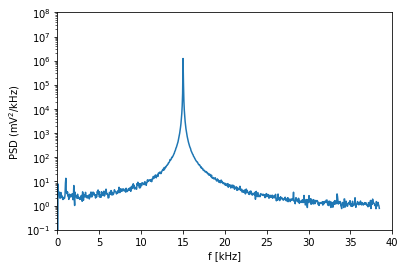

In [3]:
T,f,psd = process_text_file("pass1/raw_waveforms_15khz.txt")


plt.plot(f,psd,label="data")
plt.semilogy()
plt.xlim(0,40.0)
plt.ylim(0.1,1E8)
plt.xlabel("f [kHz]")
plt.ylabel("PSD (${\\rm mV}^2/{\\rm kHz}$)")

# example finding peak in PSD:
fmax = f[np.argmax(psd)]
print("peak at ", fmax, " kHz")






processing file:   pass1/raw_waveforms_1khz.txt
peak at  1.0  kHz has vrms =  378.19841063526127
processing file:   pass1/raw_waveforms_5khz.txt
peak at  5.0  kHz has vrms =  370.33111732738735
processing file:   pass1/raw_waveforms_10khz.txt
peak at  10.0  kHz has vrms =  329.6115740787904
processing file:   pass1/raw_waveforms_15khz.txt
peak at  15.0  kHz has vrms =  247.84625885477706
processing file:   pass1/raw_waveforms_20khz.txt
peak at  20.0  kHz has vrms =  164.67231865538403
processing file:   pass1/raw_waveforms_25khz.txt
peak at  25.0  kHz has vrms =  105.14620024998068
processing file:   pass1/raw_waveforms_30khz.txt
peak at  30.0  kHz has vrms =  67.11575792864964
processing file:   pass1/raw_waveforms_35khz.txt
peak at  35.050000000000004  kHz has vrms =  52.249696737477294


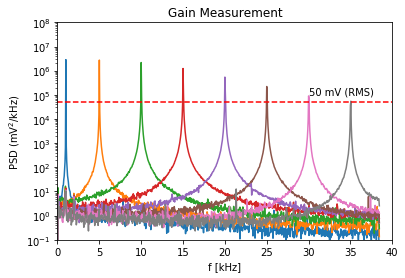

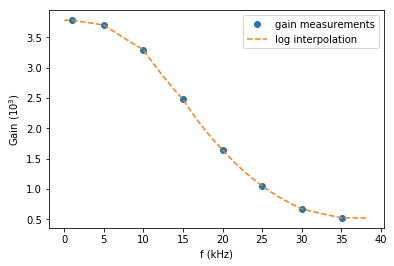

In [4]:
# gain analysis

vin = 50.0 # mV
attenuation = 0.500

# discrete frequency and gain measurement points:
fp = np.array([]) # frequency values
gp = np.array([]) # gain frequencies

gain_tags = ["1khz", "5khz", "10khz", "15khz", "20khz", "25khz", "30khz", "35khz", ]
for tag in gain_tags:
    file = "pass1/raw_waveforms_" + tag + ".txt"
    print("processing file:  ", file)
    T,f,psd = process_text_file(file)
    plt.plot(f,psd)
    
    ipeak = np.argmax(psd)
    fmax = f[ipeak]
    vmax = (psd[ipeak]/T)**0.5
    print("peak at ", fmax, " kHz has vrms = ", vmax)
    gain = attenuation * vmax / vin
    fp = np.append(fp, fmax)
    gp = np.append(gp, gain)
    
plt.semilogy()
plt.xlim(0,40.0)
plt.ylim(0.1,1E8)
plt.xlabel("f [kHz]")
plt.ylabel("PSD (${\\rm mV}^2/{\\rm kHz}$)")
    
vbm = 50
bmy = T * vbm**2 
plt.plot([0,40],[bmy,bmy],"r--", label="50 mVrms")

plt.text(30,2*bmy,"50 mV (RMS)")
plt.title("Gain Measurement")    
plt.savefig("gain_raw.pdf")
plt.show()

plt.plot(fp,gp,"o",label="gain measurements")
ff = f
gf = np.exp(np.interp(f,fp,np.log(gp)))
plt.plot(ff,gf,"--", label="log interpolation")

plt.xlabel("f (kHz)")
plt.ylabel("Gain ($10^3$)")
plt.legend()






processing file:   pass1/raw_waveforms_r1m.txt
processing file:   pass1/raw_waveforms_r100k.txt
processing file:   pass1/raw_waveforms_r10k.txt


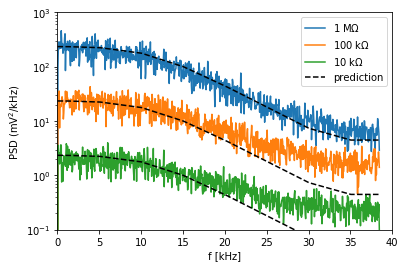

In [5]:
# johnson noise comparison with prediction:


r_tags = ["r1m", "r100k", "r10k"]
r_lbls = ["$1\;\\mathrm{M}\\Omega$", 
"$100\;\\mathrm{k}\\Omega$",          
"$10\;\\mathrm{k}\\Omega$"]

for tag,lbl in zip(r_tags,r_lbls):
    file = "pass1/raw_waveforms_" + tag + ".txt"
    print("processing file:  ", file)
    T,f,psd = process_text_file(file)
    plt.plot(f,psd,label=lbl)

fkt = 16.4 # 4kT = 16.4 uV^2 / kHz MOhm    
r_vals = np.array([1.0,0.1,0.01])
for r in r_vals:
    plt.plot(ff,r*fkt*(gf**2),"k--")
plt.plot(0,0,"k--",label="prediction")
    
plt.semilogy()
plt.xlim(0,40.0)
plt.ylim(0.1,1E3)
plt.xlabel("f [kHz]")
plt.ylabel("PSD (${\\rm mV}^2/{\\rm kHz}$)")
plt.legend()   
plt.savefig("noise_vs_pred.pdf")

measured value:   15.4


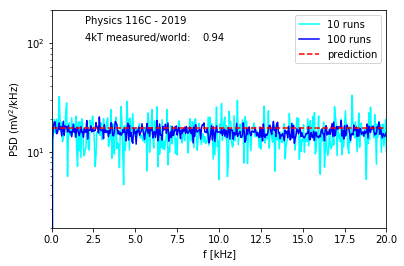

In [6]:

T,f,psda = process_text_file("pass1/raw_waveforms_r1m.txt")
T,f,psdb = process_text_file("pass1/raw_waveforms_r1m_100runs.txt")

cpsda = psda / gf**2
cpsdb = psdb / gf**2

flat = cpsdb[(f<20.0)]
flat = flat[1:]
meas = np.around(np.mean(flat),1)
print("measured value:  ", meas)

plt.plot(f,cpsda,color="cyan",label="10 runs")
plt.plot(f,cpsdb,color="blue",label="100 runs")
plt.plot([0,20],[fkt,fkt],"r--",label="prediction")
plt.semilogy()
plt.xlim(0,20.0)
plt.ylim(2.0,2E2)
plt.xlabel("f [kHz]")
plt.ylabel("PSD (${\\rm mV}^2/{\\rm kHz}$)")
plt.legend()   

top = 150
x   = 0.70
plt.text(2,   top,"Physics 116C - 2019")
plt.text(2,   top*x, "4kT measured/world:  ")
plt.text(9.0, top*x, np.around(meas/fkt,2))
plt.savefig("final.pdf")


